In [24]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from xskillscore import crps_ensemble, crps_gaussian
module_path = '/home/jupyter-aaron/Postprocessing/PP_EUPP'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [25]:
def fair_crps_ensemble(observations, forecasts, axis=0):

    # Convert inputs to numpy arrays if they're not already
    forecasts = np.asarray(forecasts)
    observations = np.asarray(observations)
    
    if axis != 1:
        forecasts = np.moveaxis(forecasts, axis, 1)
    
    # Get number of ensemble members
    m = forecasts.shape[1]
    
    # Calculate dxy: sum of absolute differences between forecasts and observations
    # Add a dimension to observations to allow broadcasting
    observations_expanded = np.expand_dims(observations, axis=1)
    dxy = np.sum(np.abs(forecasts - observations_expanded), axis=1)
    
    # Calculate dxx: sum of absolute differences between all pairs of ensemble members
    # Add dimensions to enable broadcasting for pairwise differences
    forecast_i = np.expand_dims(forecasts, axis=2)  # [batch, ens, 1, ...]
    forecast_j = np.expand_dims(forecasts, axis=1)  # [batch, 1, ens, ...]
    dxx = np.sum(np.abs(forecast_i - forecast_j), axis=(1, 2))
    
    # Calculate CRPS using the kernel approximation formula
    crps = dxy / m - dxx / (m * (m - 1) * 2)
    
    return crps

In [26]:
test_rfcs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_observation.nc")

test_rfcs=test_rfcs
obs=obs

In [27]:
target='t2m'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars(['z','tcc', 'sd','u100', 'w100', 'u', 'w700','v100', 'v'])

In [28]:
#normalizing
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

In [29]:
def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds

In [30]:
#dummy_norm=minmax_normalize(dummy,min_max_values)
#fcs_norm=dummy_norm
fcs_10 = test_rfcs
dummy=test_rfcs

In [31]:
#reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 33,32, 8), n_heads=8,mlp_mult=4,projection_channels=64)

In [32]:
#this is where the last run is stored 
checkpoint_path = f'/home/jupyter-xavi/results/Transformerweights/t2m/epochs15predictors8CRPSlambda0.02k3.3.pth'#epochs15predictors14CRPSlambda0.02k3.3.pth
# Load the checkpoint

checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1551521


In [33]:
#turn the normalized reforecasts into a tensor
#fcs_norm_whole= fcs_norm.to_array(dim='variable')
fcs_norm_whole= test_rfcs.to_array(dim='variable')
rearranged_10= fcs_norm_whole.transpose('time', 'number','step','latitude', 'longitude' , 'variable')
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

torch.Size([209, 11, 20, 32, 33, 8])


In [34]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 32, 33, 8])


In [35]:
print(list(test_rfcs.data_vars))

['t2m', 't', 'u10', 'v10', 'mx2t6', 'mn2t6', 'w10', 'p10fg6']


In [36]:
import torch
postpro_10_whole = torch.empty((209,11,20,32,33,8)) #(209,11,20,32,33,14)

#Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [37]:
#MBM_all=np.load("/home/jupyter-xavi/ClassicalMBM/t2m/MBM_t2m_all.npy")
#MBM_one=np.load("/home/jupyter-xavi/ClassicalMBM/t2m/MBM_t2m_one.npy")
#postpro_1_whole = torch.load("postpro_1_whole_t2m_all.pt")
# = torch.load("postpro_10_whole_t2m_all.pt")
ensemble_all=postpro_10_whole[...,0]
#ensemble_one = postpro_1_whole[...,0]
values_tar = fcs_whole_notnorm_tensor[:,:,:,:,:,0] #torch.Size([26, 11, 32, 33])
scale_std, scale_mean= torch.std_mean(values_tar, dim=1, unbiased=True)
scaled_ensemble_all=(ensemble_all * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)).permute(1, 0, 2, 3, 4)
#scaled_ensemble_one=(ensemble_one * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)).permute(1, 0, 2, 3, 4)

In [38]:
# Define coordinates with member first

coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}    


# Define dimensions with member first
dims_forecast = ('member','time','step','latitude', 'longitude')

# Convert numpy arrays to xarray DataArray with the specified order
#MBM_all=xr.DataArray(np.transpose(MBM_all,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
#MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_all = xr.DataArray(scaled_ensemble_all, coords=coords_forecast, dims=dims_forecast)
#full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)
# Compute mean and std across the member dimension
mean_all = full_ensemble_all.mean(dim='member')
std_all = full_ensemble_all.std(dim='member')

#mean_one = full_ensemble_one.mean(dim='member')
#std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step','latitude', 'longitude' )#'latitude', 'longitude'
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

In [39]:
ensemble_all=postpro_10_whole[...,0]
tf_mu=torch.mean(ensemble_all,axis=1)
tf_std=torch.std(ensemble_all,axis=1)
tf_mu=tf_mu*scale_std + scale_mean
tf_std=torch.exp(tf_std)*scale_std
#MBM_mu=np.mean(MBM_all,axis=1)
#MBM_std=np.std(MBM_all,axis=1)

In [40]:
coords_forecast = {
    'time': obs['time'],  # time dimension
    'step':obs['step'],
    'latitude': obs['latitude'],  # Latitude dimension
    'longitude':obs['longitude'],  # Longitude dimension
}
dims_forecast = ('time','step','latitude', 'longitude' )  # Dimensions in order


In [41]:
tf_mu = xr.DataArray(tf_mu, coords=coords_forecast, dims=dims_forecast)
tf_std =xr.DataArray(tf_std, coords=coords_forecast, dims=dims_forecast)
#MBM_mu = xr.DataArray(MBM_mu, coords=coords_forecast, dims=dims_forecast)
#MBM_std =xr.DataArray(MBM_std, coords=coords_forecast, dims=dims_forecast)

In [42]:
np.save("TF_mu.npy", tf_mu)
np.save("TF_std.npy",tf_std)

In [43]:
Leadtimes=list(fcs_10.step.values)
CRPS_OG=[]
CRPS_TF=[]
CRPS_MBM=[]
for i in range(len(fcs_10.step)):
    mu_OG=fcs_rearranged_10.isel(step=i).sel(variable='t2m').mean(dim='number')
    sigma_OG=fcs_rearranged_10.isel(step=i).sel(variable='t2m').std(dim='number')
    mu_postpro=tf_mu.isel(step=i)
    sigma_postpro= tf_std.isel(step=i)
    CRPS_P = crps_gaussian(obs.isel(step=i),mu_postpro,sigma_postpro).values
    CRPS_O = crps_gaussian(obs.isel(step=i),mu_OG,sigma_OG).values
    CRPS_OG.append(CRPS_O.item())
    CRPS_TF.append(CRPS_P.item())
    #mu_MBM=MBM_mu.isel(step=i)
    #sigma_MBM= MBM_std.isel(step=i)
    #CRPS_M = crps_gaussian(obs.isel(step=i),mu_MBM,sigma_MBM).values
    #CRPS_MBM.append(CRPS_M.item()##)

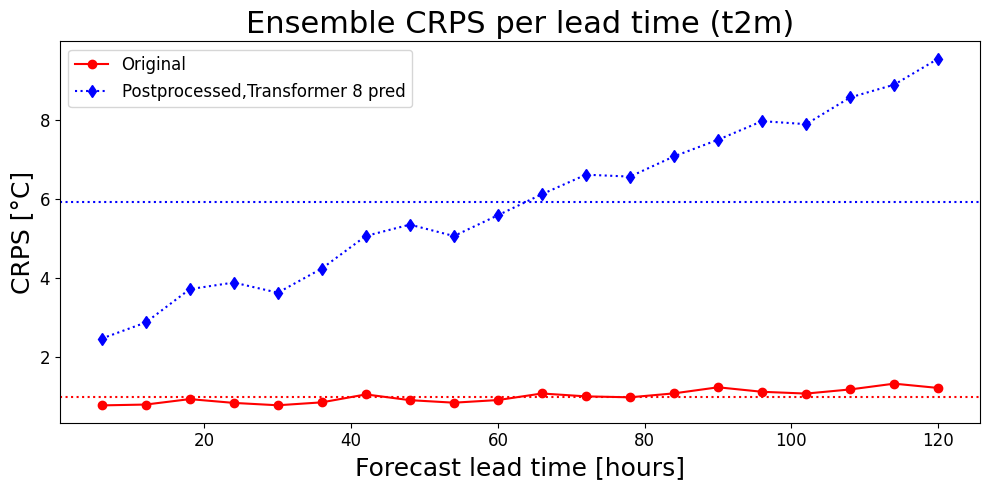

In [46]:
#CPRS WITH GAUSSIAN ASSUMPTION
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF, color='blue',linestyle=':', marker='d' ,label='Postprocessed,Transformer 8 pred')
#plt.plot(Leadtimes, CRPS_MBM, color='black',linestyle=':', marker='*', label='Postprocessed, Classical MBM All pred')


plt.axhline(y=np.mean(CRPS_OG), color='red',linestyle=':')
plt.axhline(y=np.mean(CRPS_TF), color='blue',linestyle=':')
#plt.axhline(y=np.mean(CRPS_MBM), color='black',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (t2m)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [°C]', fontsize=18)

# Set y-axis limits and x-axis ticks
#plt.xlim(0,124)
#plt.ylim(0.6,1.38)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()